In [7]:
from urllib.request import urlopen
from IPython.display import HTML

from liblet import ANTLR, Tree, Stack, warn

# Da JSON a HTML

In [8]:
# usiamo una grammatica "pronta"

with urlopen('https://raw.githubusercontent.com/antlr/grammars-v4/master/json/JSON.g4') as inf:
    grammar = inf.read().decode('utf-8')

Json = ANTLR(grammar)

In [9]:
#Json.print_grammar()

In [10]:
#print(Json.source['Parser'])

## L'albero di parsing

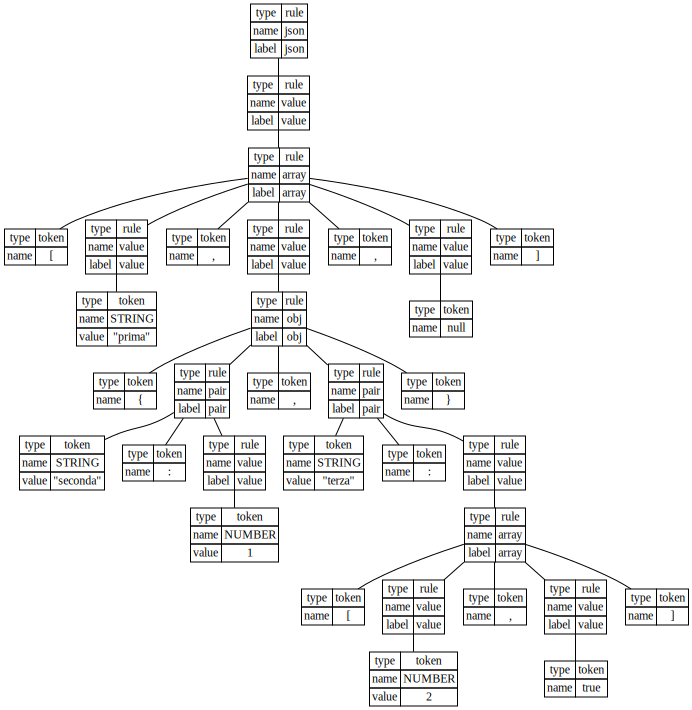

In [11]:
document = """
[   "prima",
    {
        "seconda": 1, 
        "terza": [2, true]
    },
    null
]
"""
parse_tree = Json.tree(document, 'json')
parse_tree

## Costruzione dell'AST

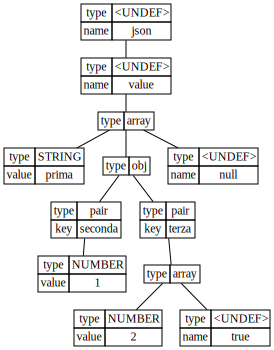

In [12]:
def NUMBER(tree):
    return Tree({'type': 'NUMBER', 'value': int(tree.root['value'])})

def STRING(tree):
    return Tree({'type': 'STRING', 'value': tree.root['value'][1:-1]})

def pair(tree):
    key, _, value = tree.children
    key = key.root['value'][1:-1]
    value = [to_ast(value.children[0])]
    return Tree({'type': 'pair', 'key': key}, value)

def obj(tree):
    pairs = [to_ast(child) for child in tree.children[1::2]]
    return Tree({'type': 'obj'}, pairs)

def array(tree):
    values = [to_ast(child.children[0]) for child in tree.children[1::2]]
    return Tree({'type': 'array'}, values)

DISPATCH_TABLE = {
    'NUMBER': NUMBER,
    'STRING': STRING,
    'pair': pair,
    'obj': obj,
    'array': array
}

def to_ast(tree):
    name = tree.root['name']
    if name in DISPATCH_TABLE:
        return DISPATCH_TABLE[name](tree)
    ast_children = [to_ast(child) for child in tree.children] if tree.children else None
    return Tree({'type': '<UNDEF>', 'name': tree.root['name']}, ast_children)

to_ast(parse_tree)

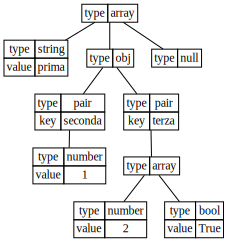

In [13]:
def STRING(tree):
    return Tree({'type': 'string', 'value': tree.root['value'][1:-1]})

def NUMBER(tree):
    return Tree({'type': 'number', 'value': tree.root['value']})

def null(tree):
    return Tree({'type': 'null'})

def boolean(tree):
    return Tree({'type': 'bool', 'value': True if tree.root['name'] == 'true' else False})

def value(tree):
    child = tree.children[0]
    return json_ast(child)

def array(tree):
    values = tree.children[1::2] 
    return Tree({'type': 'array'}, [json_ast(tree) for tree in values])

def pair(tree):
    name, _, value = tree.children
    return Tree({'type': 'pair', 'key': name.root['value'][1:-1]}, [json_ast(tree.children[2])])    

def obj(tree):
    pairs = tree.children[1::2]
    return Tree({'type': 'obj'}, [json_ast(tree) for tree in pairs])

def json(tree):
    return json_ast(tree.children[0])

JSON_DISPATCH_TABLE = {
    'null': null,
    'STRING': STRING,
    'NUMBER': NUMBER,
    'true': boolean,
    'false': boolean,
    'value': value,
    'array': array,
    'pair': pair,
    'obj': obj,
    'json': json
}

def json_ast(tree):
    return JSON_DISPATCH_TABLE[tree.root['name']](tree)

ast = json_ast(parse_tree)
ast

## Dall'AST all'HTML

Usando la pila delle chiamate ricorsive.

In [14]:
def ast2html(tree):
    node_type = tree.root['type']
    if node_type == 'bool':
        return '☑' if tree.root['value'] else '☐'
    elif node_type == 'null':
        return '␀'
    elif node_type in ('string', 'number'):
        return tree.root['value']
    elif node_type == 'array':
        values = ['<tr><td>{}</td></tr>'.format(ast2html(child)) for child in tree.children]
        return '<table class="json">{}</table>'.format(''.join(values))
    elif node_type == 'pair':
        return '<tr><th>{}</th><td>{}</td>'.format(tree.root['key'], ast2html(tree.children[0]))
    elif node_type == 'obj':
        pairs = [ast2html(child) for child in tree.children]
        return '<table class="json">{}</table>'.format(''.join(pairs))

In [15]:
document = """
[   "prima",
    {
        "seconda": 1, 
        "terza": [
            2, 3, null, "quarta", [
                "quinta",
                {
                    "sesta": true, 
                    "settima": false
                }
            ]
        ]
    }
]
"""

html = ast2html(json_ast(Json.tree(document, 'json')))
html

'<table class="json"><tr><td>prima</td></tr><tr><td><table class="json"><tr><th>seconda</th><td>1</td><tr><th>terza</th><td><table class="json"><tr><td>2</td></tr><tr><td>3</td></tr><tr><td>␀</td></tr><tr><td>quarta</td></tr><tr><td><table class="json"><tr><td>quinta</td></tr><tr><td><table class="json"><tr><th>sesta</th><td>☑</td><tr><th>settima</th><td>☐</td></table></td></tr></table></td></tr></table></td></table></td></tr></table>'

In [16]:
STYLE = """<style>
.json * {
    border: 1pt solid green !important; 
    text-align: left !important; 
    background: white;
}
</style>"""

HTML(STYLE + html)

# Da tabella HTML a matrice

In [17]:
HtmlTable = ANTLR(r"""grammar HtmlTable;

table: '<table>' row+ '</table>' ;
row: '<tr>' col+ '</tr>' ;
col: '<td>' DATA '</td>' ;

DATA: [0-9]+ ;
WS: [ \t\n]* -> skip ;
""")

## L'albero di parsing

In [18]:
table = """
<table>
    <tr><td>1</td><td>2</td><td>3</td></tr>
    <tr><td>4</td><td>5</td><td>6</td></tr>
    <tr><td>7</td><td>8</td><td>9</td></tr>
    <tr><td>10</td><td>11</td><td>12</td></tr>
</table>
"""

HTML('{}<div class=json>{}</div>'.format(STYLE, table))

1,2,3
4,5,6
7,8,9
10,11,12


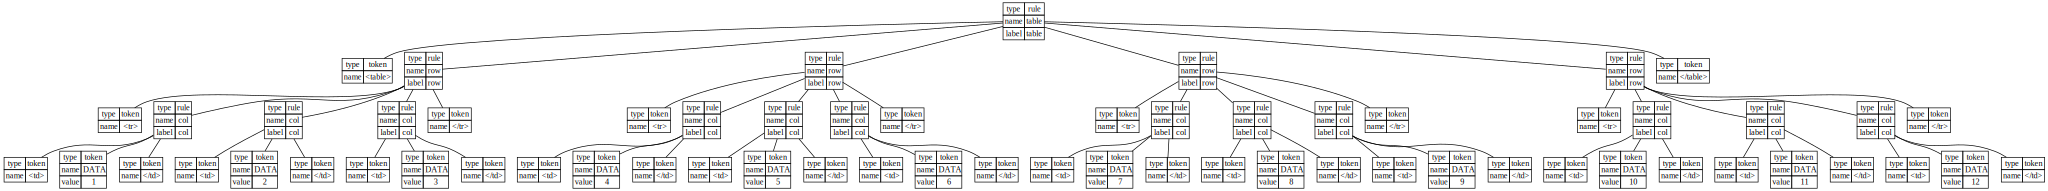

In [19]:
parse_tree = HtmlTable.tree(table, 'table')
parse_tree

## Cosruzione dell'AST

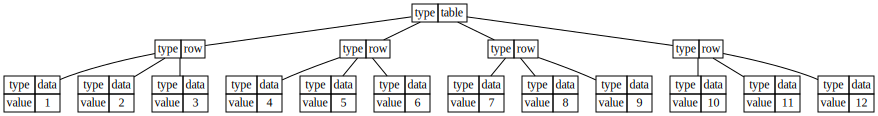

In [20]:
def DATA(tree):
    return Tree({'type': 'data', 'value': int(tree.root['value'])})

def row(tree):
    cols = tree.children[1:-1] 
    return Tree({'type': 'row'}, [table_ast(tree.children[1]) for tree in cols])

def table(tree):
    rows = tree.children[1:-1] 
    return Tree({'type': 'table'}, [table_ast(tree) for tree in rows])
        
HTML_DISPATCH_TABLE = {
    'DATA': DATA,
    'row': row,
    'table': table,
}

def table_ast(tree):
    return HTML_DISPATCH_TABLE[tree.root['name']](tree)

ast = table_ast(parse_tree)
ast

## Dall'AST alla matrice

Usando una struttura dati esterna.

In [21]:
STACK = Stack()

def ast2mat(tree):
    if tree.root['type'] == 'data':
        STACK.push(tree.root['value'])
    elif tree.root['type'] in ('row', 'table'):
        for child in tree.children: ast2mat(child)
        vals = [STACK.pop() for _ in range(len(tree.children))]
        STACK.push(vals[::-1])

ast2mat(ast)
mat = STACK.pop()
mat

[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]

## E tornare all'HTML?

In [22]:
json = str(mat)
json

'[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]'

In [23]:
HTML(ast2html(json_ast(Json.tree(json, 'json'))))

1
2
3
4
5
6
7
8
9
10
11


## Decorando i nodi

In [24]:
table = """
<table>
    <tr><td>1</td><td>2</td><td>3</td></tr>
    <tr><td>4</td><td>5</td><td>6</td></tr>
    <tr><td>7</td><td>8</td><td>9</td></tr>
    <tr><td>10</td><td>11</td><td>12</td></tr>
</table>
"""

ast = table_ast(HtmlTable.tree(table, 'table'))


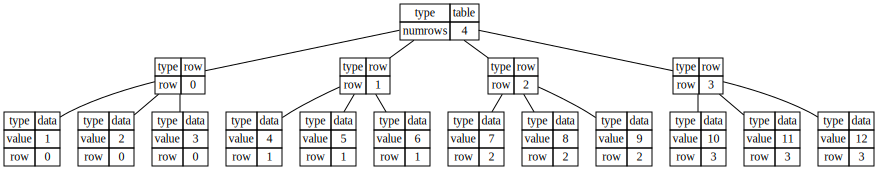

In [25]:
def add_rownum(tree, n):
    if tree.root['type'] == 'table':
        n = 0
        for child in tree.children:
            add_rownum(child, n)
            n += 1
        tree.root['numrows'] = n
    elif tree.root['type'] in 'row':
        tree.root['row'] = n
        for child in tree.children:
            add_rownum(child, n)
    elif tree.root['type'] in 'data':
        tree.root['row'] = n
        
add_rownum(ast, -1)
ast

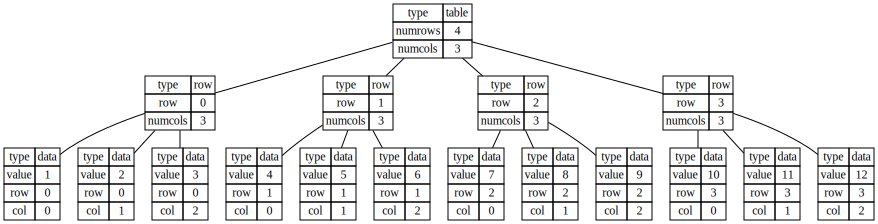

In [26]:
def add_colnum(tree, n):
    if tree.root['type'] == 'table':
        for child in tree.children:
            add_colnum(child, n)
        numcols = tree.children[0].root['numcols']
        for child in tree.children[1:]:
            if child.root['numcols'] != numcols:
                warn('riga {} ha {} colonne, non {}'.format(child.root['row'], child.root['numcols'], numcols))
                return
        tree.root['numcols'] = numcols
    elif tree.root['type'] in 'row':
        n = 0
        for child in tree.children:
            add_colnum(child, n)
            n += 1
        tree.root['numcols'] = n
    elif tree.root['type'] in 'data':
        tree.root['col'] = n
        
add_colnum(ast, -1)
ast

In [27]:
def popmat(tree):
    r, c = tree.root['numrows'], tree.root['numcols']
    mat = [[None for _ in range(c)] for _ in range(r)]
    def fill(tree):
        if tree.root['type'] == 'data':
            mat[tree.root['row']][tree.root['col']] = tree.root['value']
        else:
            for child in tree.children: fill(child)
    fill(tree)
    return mat

In [28]:
popmat(ast)

[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]

# Homework

* La grammatica del formato JSON ammette sia oggetti che array vuoti,
  ma le funzioni di trasformazione (vesro l'albero annotato e l'html) 
  non sono scritte per funzionare in tale caso. 
  Riuscite a correggerle?
  
* La grammatica per la tabella HTML non consente di mettere una 
  tabella dentro l'altra. Modificate la grammatica (e le funzioni
  di trasformazione ed estrazione della matrice) in modo che
  consentano di avere una tabella, o un numero, in ogni cella; in
  questo modo estrarrete una "matrice" alcuni dei quali elementi
  saranno a loro volta matrici (di interi).